In [1]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tflearn


#from PIL import Image
from tflearn.data_utils import to_categorical
from scipy.misc import imread, imresize
from sklearn.cross_validation import train_test_split
from matplotlib import ticker
%matplotlib inline


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Preprocessing the images

In [158]:
TRAIN_DIR = './data/train/'
TEST_DIR = './data/test1/'

ROWS = input_dim
COLS = input_dim
CHANNELS = 3
IMREAD_MODE = 'RGB'
interpolation = 'cubic'
input_dim = 128
num_to_train = 10000

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:num_to_train] + train_cats[:num_to_train]
random.shuffle(train_images)
#test_images =  test_images[:25]

def read_image(file_path):
    img = imread(file_path, mode=IMREAD_MODE) #IMREAD_GRAYSCALE)
    return imresize(img, (ROWS, COLS), interp=interpolation)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

#train = prep_data(train_images)
#test = prep_data(test_images)
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
        
X, X_test, Y, Y_test = train_test_split(train_images, labels, test_size=0.1, random_state=42)
X = prep_data(X)
X_test = prep_data(X_test)

Y = to_categorical(Y, 2)
Y_test = to_categorical(Y_test, 2)
print("Train shape: {}".format(X.shape))
print("Test shape: {}".format(X_test.shape))
print("input dim: " , input_dim)

Processed 0 of 18000
Processed 250 of 18000
Processed 500 of 18000
Processed 750 of 18000
Processed 1000 of 18000
Processed 1250 of 18000
Processed 1500 of 18000
Processed 1750 of 18000
Processed 2000 of 18000
Processed 2250 of 18000
Processed 2500 of 18000
Processed 2750 of 18000
Processed 3000 of 18000
Processed 3250 of 18000
Processed 3500 of 18000
Processed 3750 of 18000
Processed 4000 of 18000
Processed 4250 of 18000
Processed 4500 of 18000
Processed 4750 of 18000
Processed 5000 of 18000
Processed 5250 of 18000
Processed 5500 of 18000
Processed 5750 of 18000
Processed 6000 of 18000
Processed 6250 of 18000
Processed 6500 of 18000
Processed 6750 of 18000
Processed 7000 of 18000
Processed 7250 of 18000
Processed 7500 of 18000
Processed 7750 of 18000
Processed 8000 of 18000
Processed 8250 of 18000
Processed 8500 of 18000
Processed 8750 of 18000
Processed 9000 of 18000
Processed 9250 of 18000
Processed 9500 of 18000
Processed 9750 of 18000
Processed 10000 of 18000
Processed 10250 of 18

### Generating the Labels
(1) = Dog
(2) = Cat

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


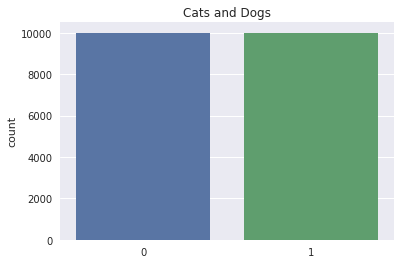

In [159]:
from tflearn.data_utils import to_categorical

labels = np.array(labels)
#Y = np.array(Y)

sns.countplot(labels)
sns.plt.title('Cats and Dogs')

In [160]:
Y.shape

(18000, 2)

### Showing some of the data

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


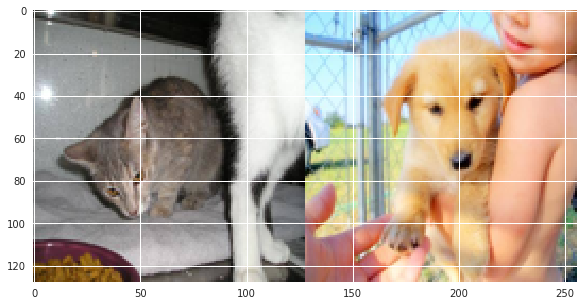

In [161]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

show_cats_and_dogs(4005)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


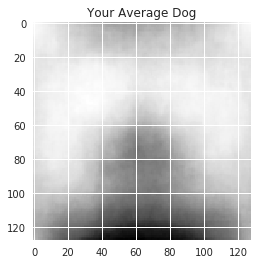

In [162]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(X) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title('Your Average Dog')

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


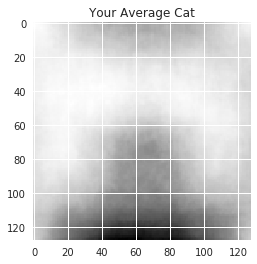

In [163]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(X) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Your Average Cat')

In [164]:
X.shape

(18000, 3, 128, 128)

In [165]:
Y.shape

(18000, 2)

### Assembling the model

In [166]:
def catdog(learn_rate=0.00001, keep_prob=0.5, optimizer='adam', input_dim=64, weights_initializer='xavier'):
    x = tflearn.input_data(shape=[None, 3, input_dim, input_dim], name='input')
    
    x = tflearn.conv_2d(x, input_dim, 3, activation='relu', scope='conv1_1', weights_init=weights_initializer)
    x = tflearn.conv_2d(x, input_dim, 3, activation='relu', scope='conv1_2', weights_init=weights_initializer)
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool1')
    
    x = tflearn.conv_2d(x, input_dim*2, 3, activation='relu', scope='conv2_1', weights_init=weights_initializer)
    x = tflearn.conv_2d(x, input_dim*2, 3, activation='relu', scope='conv2_2', weights_init=weights_initializer)
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool2')
    
    x = tflearn.conv_2d(x, input_dim*4, 3, activation='relu', scope='conv3_1', weights_init=weights_initializer)
    x = tflearn.conv_2d(x, input_dim*4, 3, activation='relu', scope='conv3_2', weights_init=weights_initializer)
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool3')
    
    x = tflearn.conv_2d(x, input_dim*8, 3, activation='relu', scope='conv4_1', weights_init=weights_initializer)
    x = tflearn.conv_2d(x, input_dim*8, 3, activation='relu', scope='conv4_2', weights_init=weights_initializer)
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool4')
    
    x = tflearn.conv_2d(x, input_dim*8, 3, activation='relu', scope='conv5_1', weights_init=weights_initializer)
    x = tflearn.conv_2d(x, input_dim*8, 3, activation='relu', scope='conv5_2', weights_init=weights_initializer)
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool5')
    
    x = tflearn.fully_connected(x, 4096, activation='relu', scope='fc6', weights_init=weights_initializer)
    x = tflearn.dropout(x, keep_prob, name='dropout1')
    
    x = tflearn.fully_connected(x, 4096, activation='relu', scope='fc7', weights_init=weights_initializer)
    x = tflearn.dropout(x, keep_prob, name='dropout2')
    
    x = tflearn.fully_connected(x, 2, activation='softmax', scope='fc8', weights_init=weights_initializer)
    
    x = tflearn.regression(x, optimizer=optimizer, loss='categorical_crossentropy', learning_rate=learn_rate)
    
    return x # x == network

In [167]:
from tflearn.metrics import Accuracy

In [168]:
learn_rate = 0.00001
keep_prob = 0.5
optimizer = 'adam'
batch_size = 100
epochs = 10

### Building the model

In [174]:
import tensorflow as tf
tflearn.init_graph()
tf.reset_default_graph()

net = catdog(learn_rate, keep_prob, optimizer, input_dim)
acc = Accuracy(name='Accuracy')

model = tflearn.DNN(net, checkpoint_path='model_cat_dog_6.tflearn', tensorboard_dir='./tmp/tflearn_logs/', max_checkpoints=3, tensorboard_verbose=0)

In [175]:
X.shape

(18000, 3, 128, 128)

In [176]:
Y.shape

(18000, 2)

In [177]:
X_test.shape

(2000, 3, 128, 128)

### Fitting the model

In [178]:
model.fit(X, Y, validation_set=(X_test, Y_test), batch_size=batch_size, n_epoch=epochs, snapshot_epoch=True, snapshot_step=100, show_metric=True, shuffle=True)
#predictions = model.predict(test, verbose=0)


Training Step: 1799  | total loss: 0.48080 | time: 148.302s
| Adam | epoch: 010 | loss: 0.48080 - acc: 0.7622 -- iter: 17900/18000
Training Step: 1800  | total loss: 0.48650 | time: 154.008s
| Adam | epoch: 010 | loss: 0.48650 - acc: 0.7550 | val_loss: 0.54035 - val_acc: 0.7320 -- iter: 18000/18000
--


### Making Predictions

In [179]:
predictions = model.predict(X_test[:50])

I am 84.48% sure this is a Dog


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


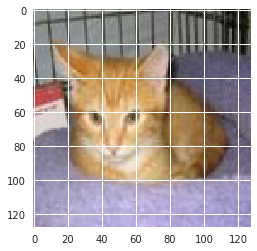

I am 86.19% sure this is a Cat


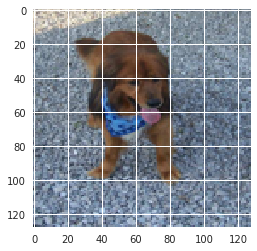

I am 88.94% sure this is a Dog


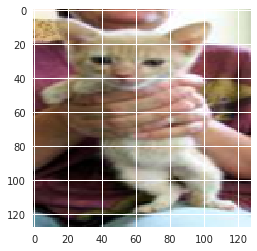

I am 92.27% sure this is a Dog


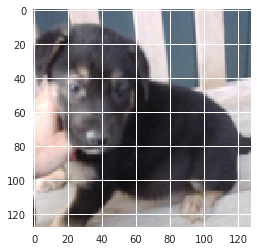

I am 59.22% sure this is a Cat


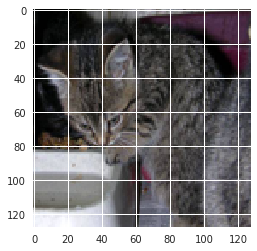

I am 93.85% sure this is a Dog


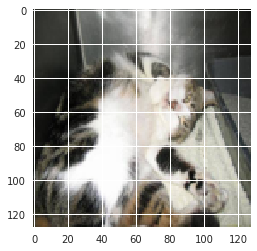

I am 82.61% sure this is a Dog


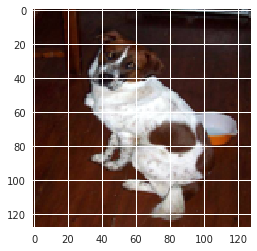

I am 58.50% sure this is a Dog


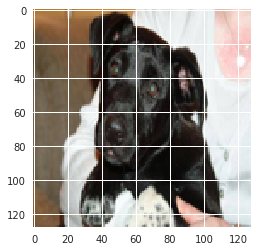

I am 69.19% sure this is a Dog


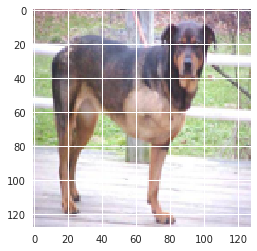

I am 83.18% sure this is a Dog


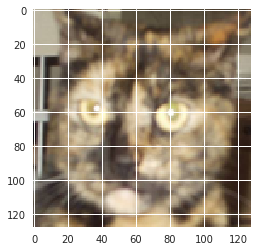

In [180]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(X_test[i].T)
    plt.show()